# Software Design Prototype Demonstration

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imutils
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage
import time

In [ ]:
# import numpy # 1.26.4
# import PIL # 11.0.0
# import matplotlib # 3.8.0
# import imutils # 0.5.4
# import cv2 # 4.10.0
# import scipy # 1.13.1
# import time

# print(numpy.__version__)
# print(PIL.__version__)
# print(matplotlib.__version__)
# print(imutils.__version__)
# print(cv2.__version__)
# print(scipy.__version__)

1.26.4
11.0.0
3.8.0
0.5.4
4.10.0
1.13.1


In [ ]:
# Template image Class
# Reference: https://www.mdpi.com/2076-3417/9/17/3598
class Template:
    def __init__(self, image_paths, a=1, b=1):
        # Load all images and convert them to numpy arrays
        images = [np.array(Image.open(img).convert("L"), dtype=np.float32) for img in image_paths]

        # Calculate mean image
        self.image = np.mean(images, axis=0)

        # Calculate standard deviation
        self.std = np.std(images, axis=0)

        # Set empirical values a and b
        self.a = a
        self.b = b

        # Calculate self.light using the formula: Ia(x,y) + max(a, b * std(x,y))
        self.light = np.clip(self.image + np.maximum(self.a, self.b * self.std), 0, 255)

        # Calculate self.dark using the formula: Ia(x,y) - max(a, b * std(x,y))
        self.dark = np.clip(self.image - np.maximum(self.a, self.b * self.std), 0, 255)

    def get_template_image(self):
        return Image.fromarray(self.image.astype(np.uint8))

    def get_light_image(self):
        return Image.fromarray(self.light.astype(np.uint8))

    def get_dark_image(self):
        return Image.fromarray(self.dark.astype(np.uint8))

In [ ]:
# Image registration and alignment
# Reference: https://pyimagesearch.com/2020/08/31/image-alignment-and-registration-with-opencv/

def align_images(image, template, maxFeatures=500, keepPercent=0.2, debug=False):
    # Convert both the input image and template to grayscale
    if len(image.shape) == 3:
        imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        imageGray = image

    if len(template.shape) == 3:
        templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    else:
        templateGray = template

    # Use ORB to detect keypoints and extract local invariant features
    orb = cv2.ORB_create(maxFeatures)
    (kpsA, descsA) = orb.detectAndCompute(imageGray, None)
    (kpsB, descsB) = orb.detectAndCompute(templateGray, None)

    # Match the features
    method = cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING
    matcher = cv2.DescriptorMatcher_create(method)
    matches = matcher.match(descsA, descsB, None)

    # Sort the matches by their distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Keep only the top matches
    keep = int(len(matches) * keepPercent)
    matches = matches[:keep]

    # Debug checking
    if debug:
        matchedVis = cv2.drawMatches(image, kpsA, template, kpsB, matches, None)
        matchedVis = imutils.resize(matchedVis, width=1000)
        cv2_imshow(matchedVis)

    # Allocate memory for the keypoints (x, y)-coordinates from the top matches
    # We'll use these coordinates to compute our homography matrix
    ptsA = np.zeros((len(matches), 2), dtype="float")
    ptsB = np.zeros((len(matches), 2), dtype="float")

    # Loop over the top matches
    for (i, m) in enumerate(matches):
        # Indicate that the two keypoints in the respective images map to each other
        ptsA[i] = kpsA[m.queryIdx].pt
        ptsB[i] = kpsB[m.trainIdx].pt

    # Compute the homography matrix between the two sets of matched points
    (H, mask) = cv2.findHomography(ptsA, ptsB, method=cv2.RANSAC)

    # Use the homography matrix to align the images
    (h, w) = template.shape[:2]
    aligned = cv2.warpPerspective(image, H, (w, h))

    # Return the aligned image
    return aligned

In [ ]:
# Create binary mask of defective pixels using image subtraction technique
# Reference:
# https://www.mdpi.com/2076-3417/9/17/3598
# https://ieeexplore.ieee.org/abstract/document/6223405

def get_marked_image(image_src, kernel_size, rotation=0, ideal=True):
    # Initialize a dictionary to store the time taken for each step
    timings = {}

    # Start timer for the initial sample conversion
    start = time.time()
    sample = np.asarray(image_src)
    timings["Convert sample to array"] = time.time() - start

    # Rotate and align the sample image if necessary
    start = time.time()
    if ideal:
        fixed = sample
    else:
        rotated = ndimage.rotate(sample, rotation)
        fixed = align_images(rotated, np.asarray(golden_image.get_template_image()))
        #, maxFeatures=750, keepPercent=0.1
    timings["Image rotation and alignment"] = time.time() - start

    # Convert to grayscale
    start = time.time()
    sample_image_gray = np.array(Image.fromarray(fixed).convert("L"), dtype=np.float32)
    timings["Convert to grayscale"] = time.time() - start

    # Apply Gaussian blur
    start = time.time()
    sample_image_blur = cv2.GaussianBlur(sample_image_gray, (kernel_size, kernel_size), 0)
    timings["Gaussian blur on sample image"] = time.time() - start

    # Blurred versions of light and dark images
    start = time.time()
    dark_blur = cv2.GaussianBlur(golden_image.dark, (kernel_size, kernel_size), 0)
    light_blur = cv2.GaussianBlur(golden_image.light, (kernel_size, kernel_size), 0)
    timings["Gaussian blur on light and dark images"] = time.time() - start

    # Dilation and erosion operations
    start = time.time()
    light_dilated = cv2.dilate(light_blur, np.ones((3, 3), np.uint8))
    dark_eroded = cv2.erode(dark_blur, np.ones((3, 3), np.uint8))
    timings["Dilation and erosion"] = time.time() - start

    # Threshold range detection
    start = time.time()
    out_of_range = np.logical_or(sample_image_blur < dark_eroded, sample_image_blur > light_dilated)
    timings["Threshold range detection"] = time.time() - start

    # Morphological opening to remove noise
    start = time.time()
    out_of_range = cv2.morphologyEx(out_of_range.astype(np.uint8), cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))
    timings["Morphological opening"] = time.time() - start

    # Create binary defect mask
    start = time.time()
    binary_defect_image = np.zeros_like(sample_image_gray, dtype=np.uint8)
    binary_defect_image[out_of_range == 1] = 255
    timings["Binary mask creation"] = time.time() - start

    # Convert to image format
    start = time.time()
    binary_image = Image.fromarray(binary_defect_image)
    timings["Convert binary mask to image"] = time.time() - start

    # Output timing information

    return binary_image

In [ ]:
# Work in Progress
# Criteria based on the ratio of number of defective pixels by total pixels
def defect_criteria(mask, max = 0.01):
  defect_pixel_count = np.sum(np.asarray(mask) == 255)
  w, h = mask.size
  ratio = defect_pixel_count / (w*h)
  is_defective = ratio > max
  return [is_defective, ratio]

# Demo

Text(0.5, 1.0, 'Dark')

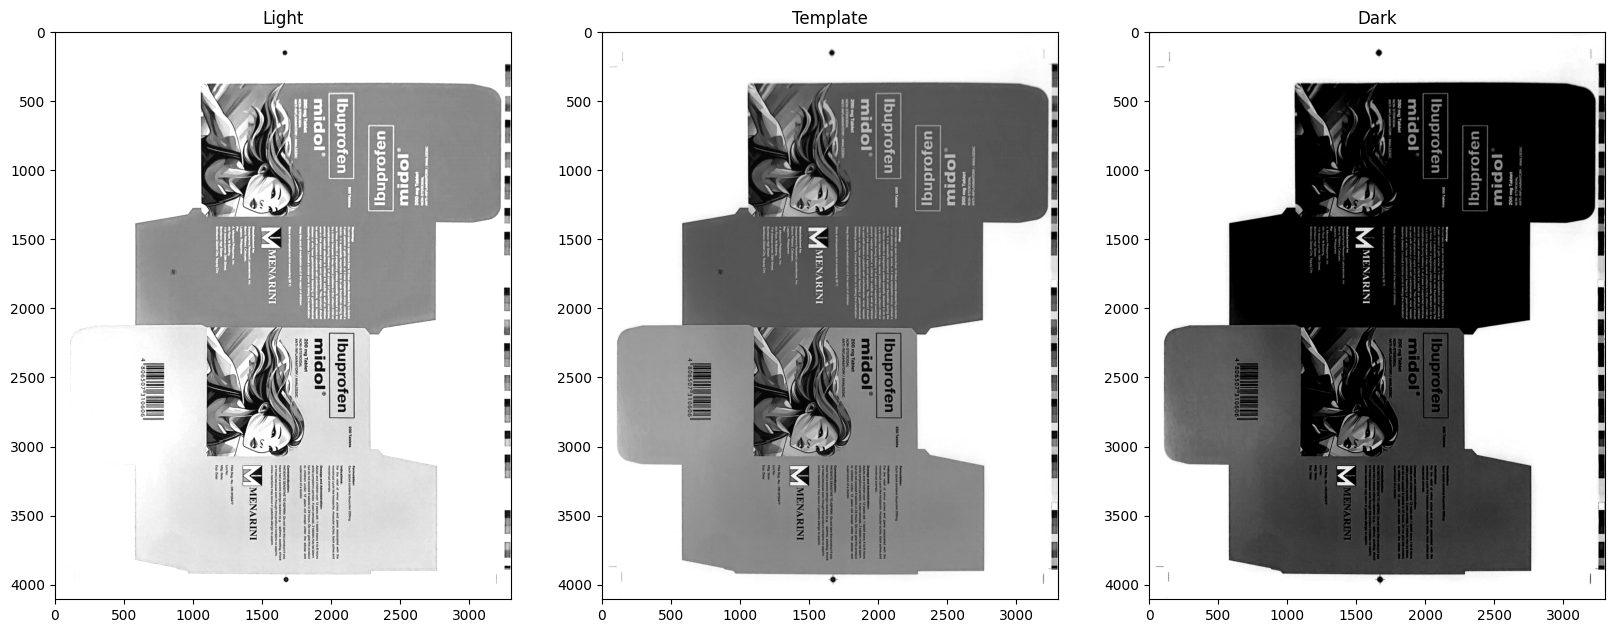

In [ ]:
image_paths = ['/content/template.png']
golden_image = Template(image_paths, a=100, b=300)

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
plt.imshow(golden_image.get_light_image(), cmap='gray')
plt.title("Light")

plt.subplot(1,3,2)
plt.imshow(golden_image.get_template_image(), cmap='gray')
plt.title("Template")

plt.subplot(1,3,3)
plt.imshow(golden_image.get_dark_image(), cmap='gray')
plt.title("Dark")

[True, 0.055232254350617724]


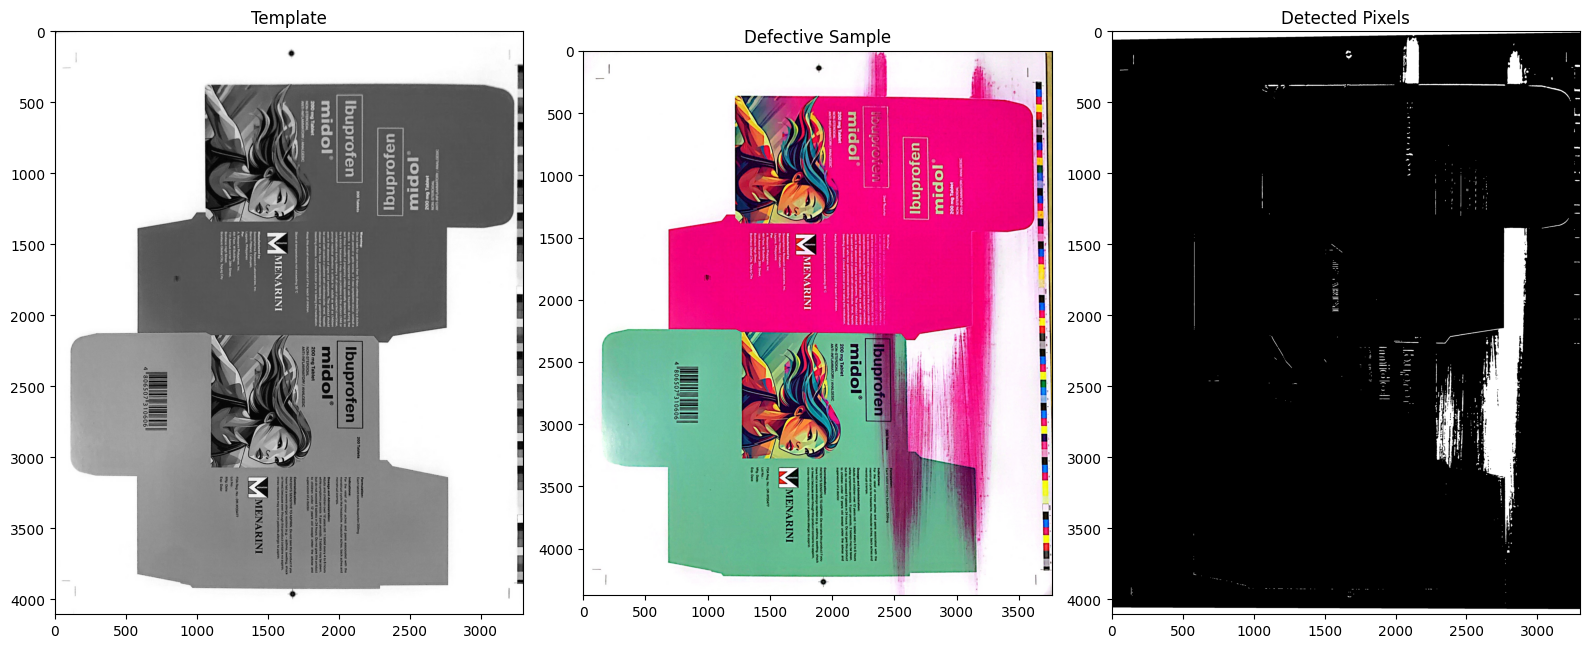

In [ ]:
defective = '/content/defect.png'

defect1_img = Image.open(defective)
marked_defect = get_marked_image(defect1_img, kernel_size=5,ideal=False)

print(defect_criteria(marked_defect))

plt.figure(figsize=(16,10))

plt.subplot(1,3,1)
plt.imshow(golden_image.get_template_image().convert("RGB"))
plt.title("Template")

plt.subplot(1,3,2)
plt.imshow(defect1_img)
plt.title("Defective Sample")

plt.subplot(1,3,3)
plt.imshow(marked_defect, cmap="gray")
plt.title("Detected Pixels")

plt.tight_layout()
plt.show()

Image 1: True 	Actual: True	Ratio: 5.523225435061772%
Image 2: True 	Actual: True	Ratio: 0.12279148031705264%
Image 3: False 	Actual: True	Ratio: 0.0%
Image 4: False 	Actual: False	Ratio: 0.0%
Image 5: True 	Actual: True	Ratio: 0.36234483165803183%
Image 6: False 	Actual: False	Ratio: 0.0%


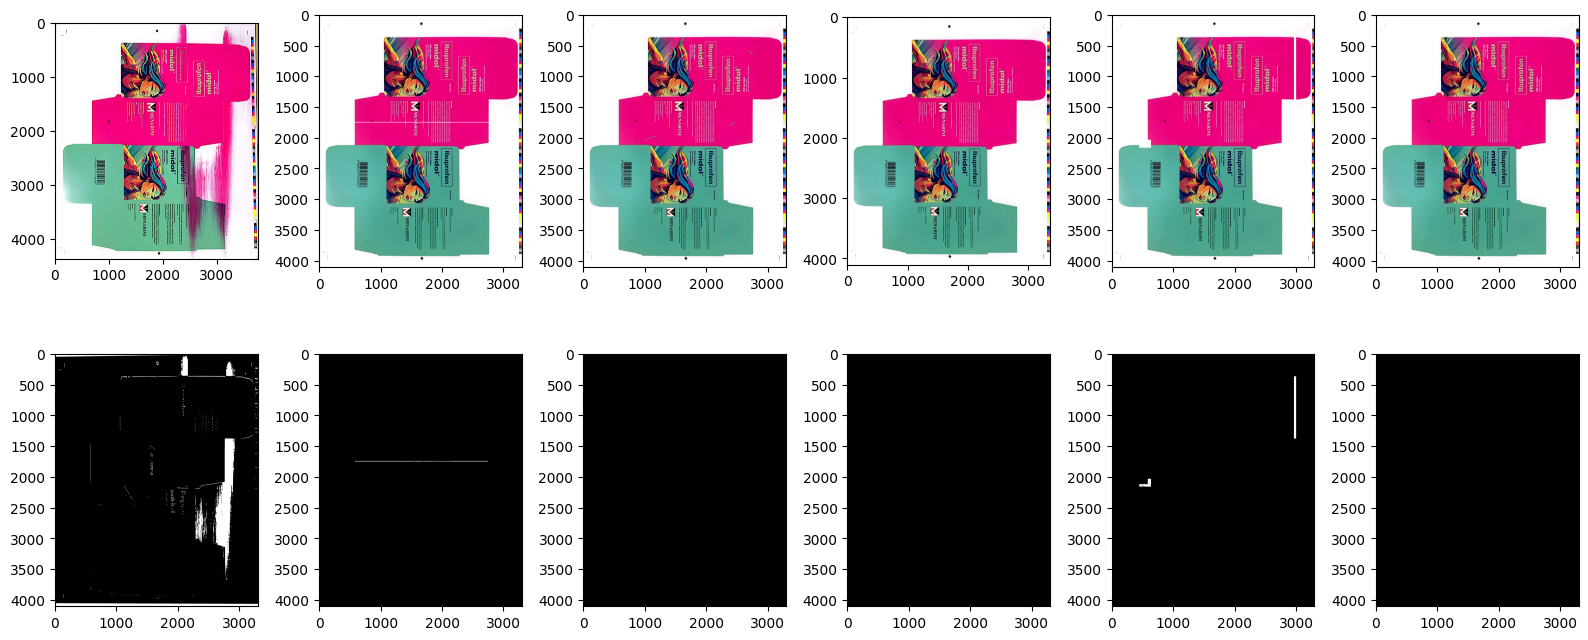

In [ ]:
image1 = '/content/defect.png'  # Defective
image2 = '/content/defect 1.png'# Defective
image3 = '/content/defect 2.png'# Defective
image4 = '/content/good 1.png'  # Good
image5 = '/content/defect 3.png'# Defective
image6 = '/content/template.png'# Good
images = [image1, image2, image3, image4, image5, image6]
actual = [True, True, True, False, True, False]

plt.figure(figsize=(16,7))

for i in range(6):
  defect1_img = Image.open(images[i])
  marked_defect = get_marked_image(defect1_img, kernel_size=5,ideal=False)
  result, ratio = defect_criteria(marked_defect, max=0.001)
  print(f"Image {i+1}: {result} \tActual: {actual[i]}\tRatio: {ratio*100}%")
  plt.subplot(2,6,i+1)
  plt.imshow(defect1_img)
  plt.subplot(2,6,i+7)
  plt.imshow(marked_defect, cmap="gray")

plt.tight_layout()
plt.show()